Testing the easily adjustable AE on the brains before they got spatial normalization to check if this will help in performance. (A small check to see if no data augmentation (data variataion) is at the root of the problem since the spatial normalization basically removed all variation in the data)

In [2]:
# from ...DementiaMRI.Architectures.VAE import VAE
from Data.load import load
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from Metrics.metrics import NMSE, SSIM, NRMSE
import glob

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K

from skimage.metrics import structural_similarity as ssim

import time

In [24]:
train, test = load(take=50, train_test_split=0.8) # unspatially normalized brains put in this path \Data\Pre-processed
print(train.shape, test.shape)

Loading images: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]

(40, 80, 96, 80) (10, 80, 96, 80)


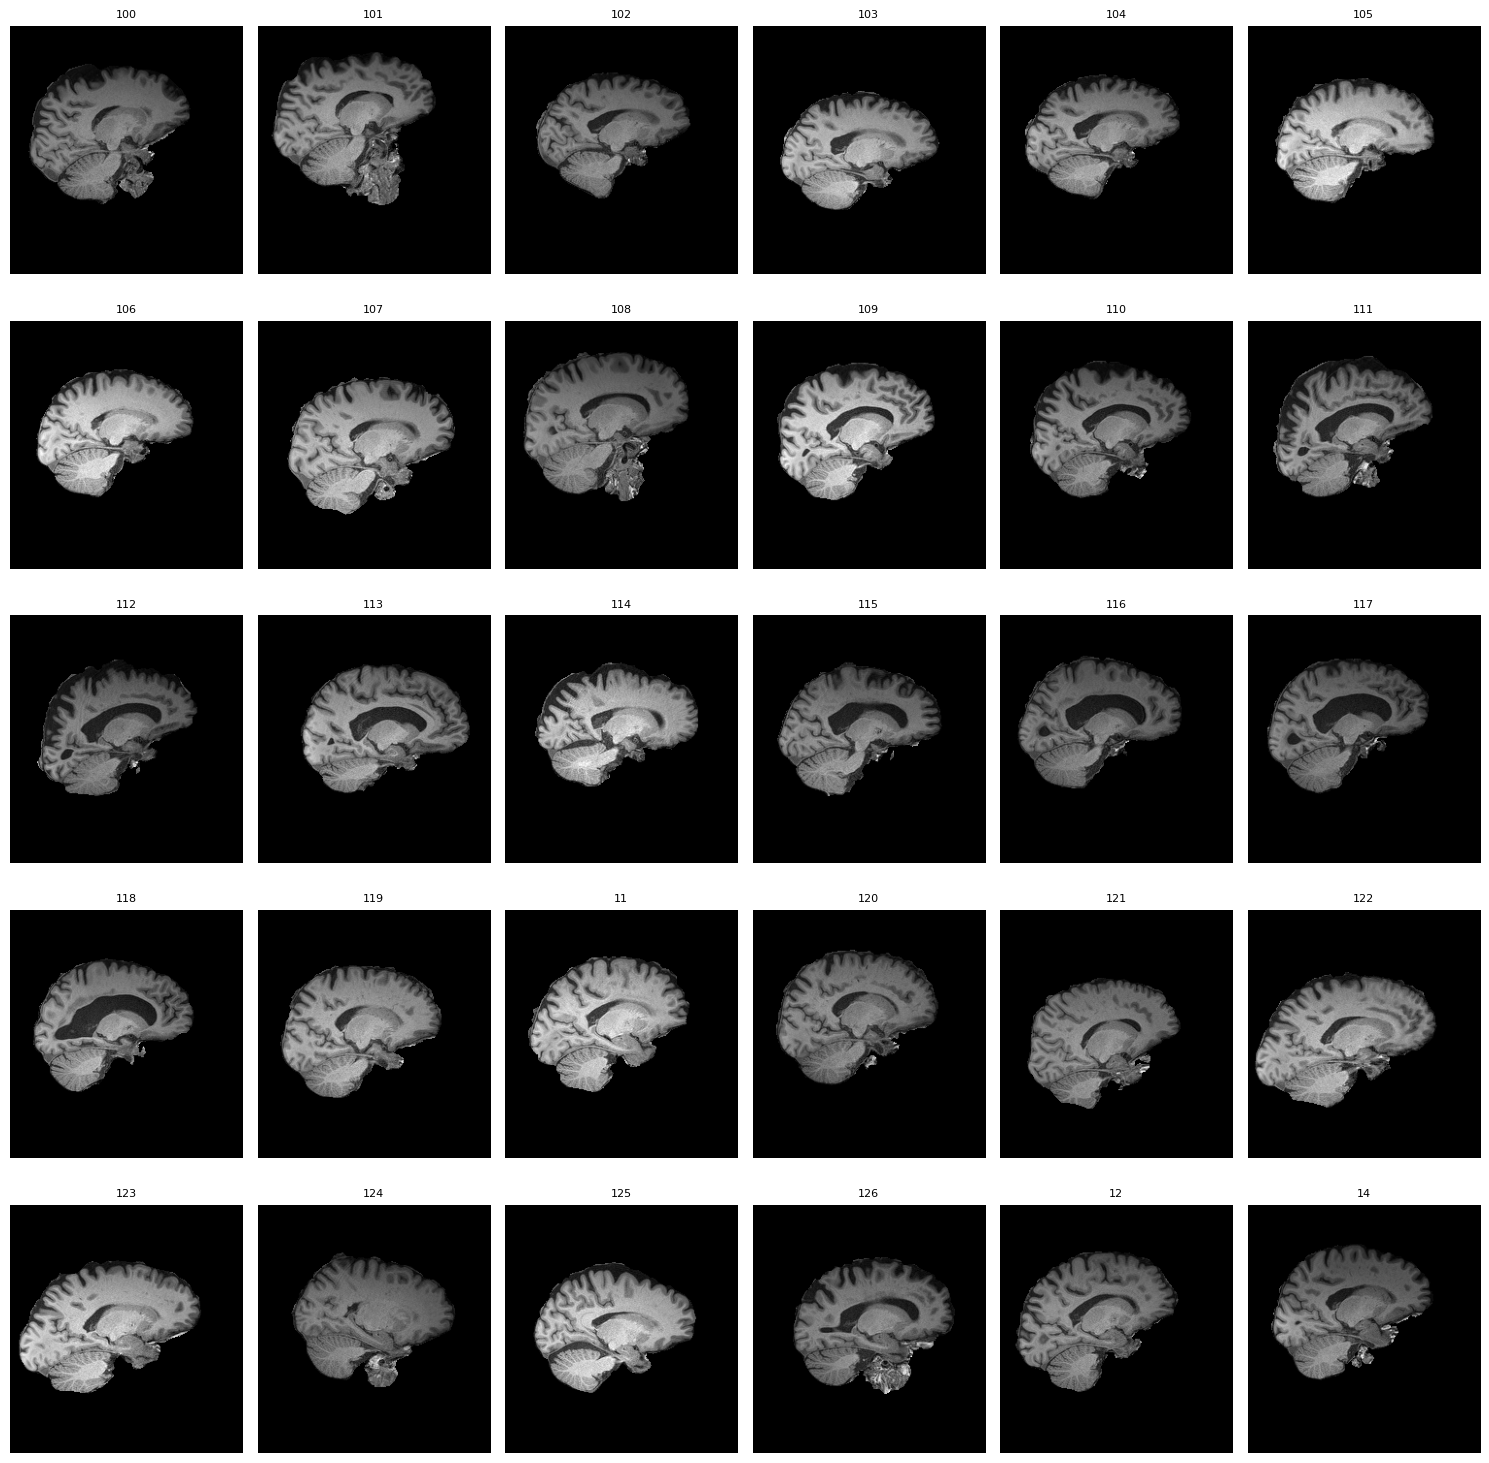

In [5]:
# Lets try to train on these instead (the step before spatial normalization)
import os
import nibabel as nib
import matplotlib.pyplot as plt
import math

# Define the folder containing the NIfTI files
folder_path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed"

# Function to plot the middle slices of images between n1 and n2 in a single figure
def plot_middle_slices_in_range(folder_path, n1, n2, axis=1):
    # Get a sorted list of all files in the directory excluding mask files
    all_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.nii.gz') and not f.endswith('_mask.nii.gz')]
    )
    
    # Filter files between n1 and n2
    selected_files = all_files[n1:n2]
    num_images = len(selected_files)
    
    # Determine grid size for the plot
    cols = math.ceil(math.sqrt(num_images))  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Number of rows in the grid
    
    # Create a figure for plotting
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten to easily iterate over axes
    
    for i, file in enumerate(selected_files):
        file_path = os.path.join(folder_path, file)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        img_data = img.get_fdata()
        
        # Calculate the middle index along axis 0
        middle_index = img_data.shape[axis] // 2
        
        # Plot the middle slice on the current axis
        axes[i].imshow(img_data[middle_index, :, :].T, cmap='gray', origin="lower")
        axes[i].set_title(file_path.split("\\")[-1].split("_")[0], fontsize=8)
        axes[i].axis('off')
    
    # Hide unused axes if the grid is larger than the number of images
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with your desired range (e.g., 5 to 15)
plot_middle_slices_in_range(folder_path, 0, 30, axis=1)

In [ ]:
class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                loss="mse", #of any other funciton
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.loss = loss
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        shape_changed = False
        if self.input_shape[-1] > 3:
            self.input_shape = list(self.input_shape) + [1]
            shape_changed = True
        if len(self.input_shape) > 4:
            self.input_shape = self.input_shape[-4:]
            shape_changed = True
        if shape_changed:
            print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        
        # - Add encoder layers
        for layer in self.encoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            print(f"After {x.shape}: {layer}") if self.debug else None

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)

        # VAE specific: Output mean and log variance
        # self.mean = layers.Dense(self.latent_dim, name="mean")(x)
        # self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
        # Sampling layer
        # def sampling(args):
        #     mean, log_var = args
        #     epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
        #     return mean + K.exp(log_var / 2) * epsilon
        # 
        # z = layers.Lambda(sampling, name="z")([self.mean, self.log_var])
        # self.encoder = Model(input_layer, [self.mean, self.log_var, z], name="encoder")

        x = layers.Dense(self.latent_dim, activation="relu")(x)
        self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=x.shape[1:])  # Latent input
        
        # Calculate the expected target shape after decoder layers
        target_shape = pre_flatten_shape[1:]

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(target_shape), activation="relu")(latent_input)
        x = layers.Reshape(target_shape)(x)

        # - Add decoder layers
        for layer in self.decoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full VAE
        #mean, log_var, z = self.encoder(input_layer)
        #autoencoder_output = self.decoder(z)
        #self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")

        # 3. Combine the encoder and decoder into a full autoencoder
        autoencoder_output = self.decoder(self.encoder(input_layer))
        self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        # self.autoencoder.compile(optimizer='adam', loss='mse')

        # 4. GPU or CPU assignment (based on self.GPU)
        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            # Set device to GPU if available
            with tf.device('/GPU:0'):
                self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)
        else:
            # Default to CPU
            self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        # No reason to delete the loss history, if we stopped the sim at epoch10,
        # then we can continue it at another point
        if not hasattr(self, "history") or not self.history:
            #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
            #self.history.history = {"loss": [], "val_loss": []}
            self.history = {"loss": [], "val_loss": []}

        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0:
                        self.save(save_path, name=f"{self.name}_epoch{epoch}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0:
                    self.save(save_path, name=f"{self.name}_epoch{epoch}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history

    def vae_loss(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""
        reconstruction_loss = self.loss(y_true, y_pred)

        # KL divergence loss
        # mean, log_var = self.encoder.input
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)

        # kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)
    
    #def sample2(mu, logvar):
    #    batch = tf.shape(mu)[0]
    #    dim = tf.shape(mu)[1]
    #    epsilon = tf.random.normal(shape=(batch, dim))
    #    return mu + tf.exp(0.5 * logvar) * epsilon

    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(path, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(path, f"{name}_decoder.keras"))
        print(f"Models saved to {path} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")

        autoencoder = tf.keras.models.load_model(autoencoder_path)
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True
        ae.history = None
        ae.debug = False

        # Compile the loaded model manually
        ae.autoencoder.compile(ae.vae_loss, optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae

Functions for plotting

In [13]:
def plot_models_training_time(models_list, fig_size=""):
    training_times = []
    names = []
    for m in models_list:
        if hasattr(m, 'training_time') and m.training_time is not None:
            training_times.append(m.training_time)
            names.append(m.name)

    if training_times:
        if fig_size: 
            plt.figure(figsize=fig_size)
        plt.bar(names, training_times)
        plt.xlabel('Model index')
        plt.ylabel('Training time (seconds)')
        plt.title('Training time of models')
        plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
        plt.show()

def compare_models_loss_history(models, log10=True, fig_size="", title="Model's val_loss history"):
    """
    Compares the loss histories of multiple models by plotting their log-transformed losses.

    Parameters:
    - models: list of model objects, each containing a 'log.history["loss"]' attribute and a 'name'.

    Returns:
    - None: Displays a plot of the loss histories.
    """
    if fig_size: 
        plt.figure(figsize=fig_size)
    for i, model in enumerate(models):
        #color = decimal_to_rgb(i, len(models))
        #color = "#{:02x}{:02x}{:02x}".format(np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        #y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]
        
        # Sorry for the mess, but I wanted this to work for two different classes
        if isinstance(model.history, tf.keras.callbacks.History):
            y = [model.history.history["val_loss"], np.log10(model.history.history["val_loss"])][log10]
        else:
            y = [model.history["val_loss"], np.log10(model.history["val_loss"])][log10]
        plt.plot(y, label=model.name) #, color=color
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss Log10") if log10 else plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_images(images, dimensions, fig_size=(10,8), titles=[], top_title="Image Gallery", cmap="viridis"):
    """
    Plots a grid of images with corresponding titles.

    Parameters:
    - images: list of numpy arrays, the images to be displayed.
    - dimensions: tuple of int (rows, cols), grid layout for images.
    - fig_size: tuple for the figure size, eg (10,8)
    - titles: list of str, the titles for each image.
    - top_title: str, optional, the title of the overall figure.

    Returns:
    - None: Displays the plot.
    """
    plt.figure(figsize=fig_size)
    plt.suptitle(top_title, fontsize=12, fontweight="bold", y=0.99)
    for i, img in enumerate(images):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        plt.imshow(img, cmap=cmap)
        if len(titles) == len(images):
            plt.title(titles[i], fontsize=10)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

def compare_models_reconstruction(brain_scan_id, models_list):
    images = []
    for m in models_list:
        latent = m.encode(test)
        recon = m.decode(latent)
        input_image = np.rot90(test[brain_scan_id][40].reshape((96, 80)))
        recon_image = np.rot90(recon[brain_scan_id][40])[:,:,0] # recon shape is 3dim we need -> 2d
        images.append(input_image)
        images.append(recon_image)
        images.append(input_image - recon_image)
    return images, latent

In [32]:
# Custom version of keras.Sequential that will also allow skip connections in the future
models_list = [

    AE(name="AE (4h, 8-64f, 128L)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),
            # (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            # (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="AE (4h 8-64f, 128L, dropout)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            # (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            # (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (4h, 16-128f, 128L, dropout)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            #(layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            #(layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (3h, 16-64f, 1024L, dropout)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128*8,
        encoder_layers=[
            #(layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            #(layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (3h, 8-32f, 258L, dropout)",
        input_shape=train.shape,
        latent_dim=256,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="VAE (4h, 8-64f, 128L)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
    ], VAE_model=True),

    AE(name="VAE (4h, 8-64f, 128L, dropout)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True),
    
    AE(name="VAE (4h, 16-128f, 128L, dropout)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True),

]

# SIMILAR VAE TO THE TEACHER MAIL TIP, BUT WITHOUT SKIP CONNECTIONS 
"""
AE(name="AE (4h, 16-128f, 128L, batchn, relu)",
    input_shape=train.shape,
    latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), #(layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), #(layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), #(layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv3D, 256, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), #(layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
    ],
    decoder_layers=[
        (layers.Conv3D, 256, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
]),"""

# models_list = [models_list[-1]]
for m in models_list: 
    #m.summary()
    m.train(train, epochs=10, batch_size=10, verbose=False) #,
            #save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
            #save_interval=100) # saves every 100 epoch btw)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 128)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 32)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 128)
Training AE (4h, 8-64f, 128L) on the CPU - 269.52s
Training AE (4h 8-64f, 128L, dropout) on the CPU - 263.87s
Training AE (4h, 16-128f, 128L, dropout) on the CPU - 643.56s
Training AE (3h, 16-64f, 1024L, dropout) on the CPU - 1086.41s
Training AE (3h, 8-32f, 258L, dropout) on the

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 787ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 795ms/step
0.21117333660147958


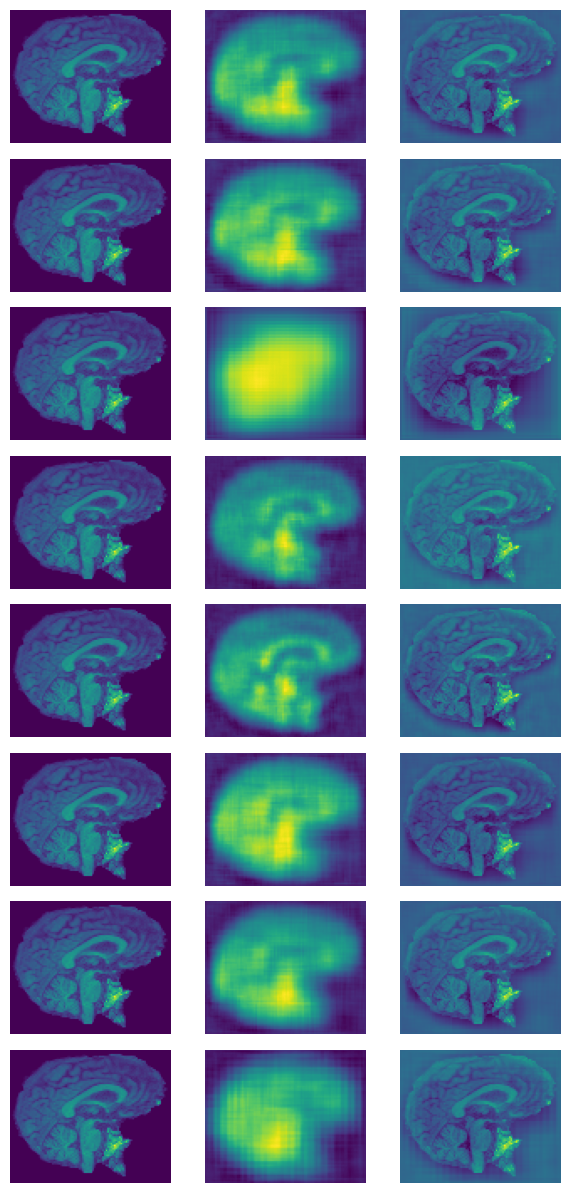

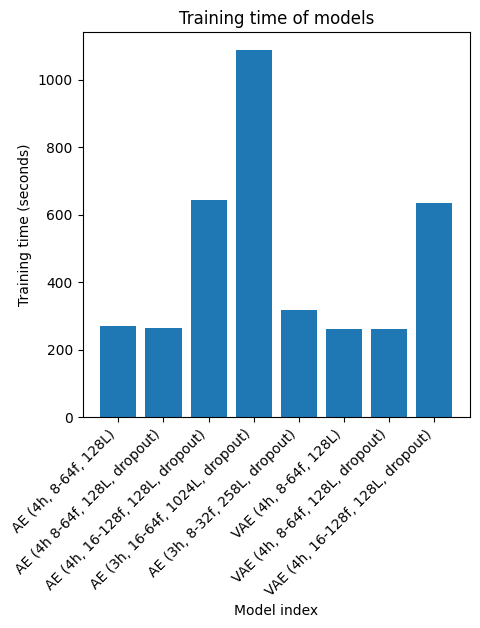

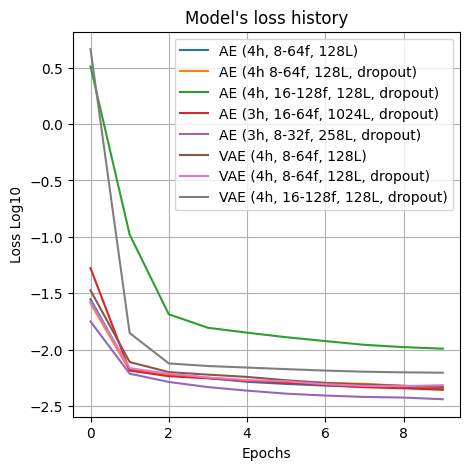

In [33]:
if 'models_list' in locals(): # if the variable exists
    images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))

#### AND WE'RE BACK TO SQUARE 1, THE GRIND NEVER STOPS (keep in mind I learnt about NN's 3 months ago.. in an extra minicourse, A newbie I AM yes)!

- NOT REALLY: Increase latent_dim (e.g., 512+).
- NOT REALLY: Increase decoder capacity (deeper & residual connections).
- MAAYBE: Skip connections (ResNet)
- MAAYBE: Lower KL weight (beta) to prevent over-regularization.
- HUH?: Use a better prior (e.g., VampPrior, Flow-based VAEs).
- YEAH MAYBE: Switch to perceptual loss (SSIM or LPIPS instead of MSE).
- OR MAYBE ACTUALLY LOOK INTO PCA (layers) CUS JON HAS THE KNOW-HOW SOME-HOW :eyes:! eh, maybe later

In [7]:
import tensorflow as tf

def MSE_loss(y_true, y_pred):
    """Mean Squared Error (MSE) loss"""
    return tf.reduce_mean(tf.square(y_true - y_pred))

def NMSE_loss(y_true, y_pred):
    """Normalized Mean Squared Error (NMSE) loss"""
    return tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true))

def NRMSE_loss(y_true, y_pred):
    """Normalized Root Mean Squared Error (NRMSE) loss"""
    range_val = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) / (range_val + 1e-8)  # Avoid division by zero

def SSIM_loss(y_true, y_pred):
    """SSIM loss (1 - SSIM for minimization)"""
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))



In [ ]:
# same good performing simple vae model, with different loss functions 
models_list2 = [
    AE(name="VAE (3h, 16-128f, 512L, dropout, MSE_loss)",
    input_shape=train.shape,
    latent_dim=512,
    encoder_layers=[
        (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
    ],
    decoder_layers=[
        (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
    ], VAE_model=True, loss=MSE_loss),

    AE(name="VAE (3h, 16-128f, 512L, dropout, NMSE_loss)",
        input_shape=train.shape,
        latent_dim=512,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True, loss=NMSE_loss),
    
    
    AE(name="VAE (3h, 16-128f, 512L, dropout, NRMSE_loss)",
        input_shape=train.shape,
        latent_dim=512,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True, loss=NRMSE_loss),
    
    
    AE(name="VAE (3h, 16-128f, 512L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=512,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True, loss=SSIM_loss)
]

for m in models_list2:
    m.train(train, epochs=5, batch_size=10, verbose=True)


images = compare_models_reconstruction(brain_scan_id=0, models_list=[models_list[-2]])
print(SSIM(images[0], images[1]))
plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Training VAE (3h, 16-128f, 512L, dropout, MSE_loss) on the CPU

KeyboardInterrupt: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 844ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 826ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 807ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 858ms/step
0.2839816800878375


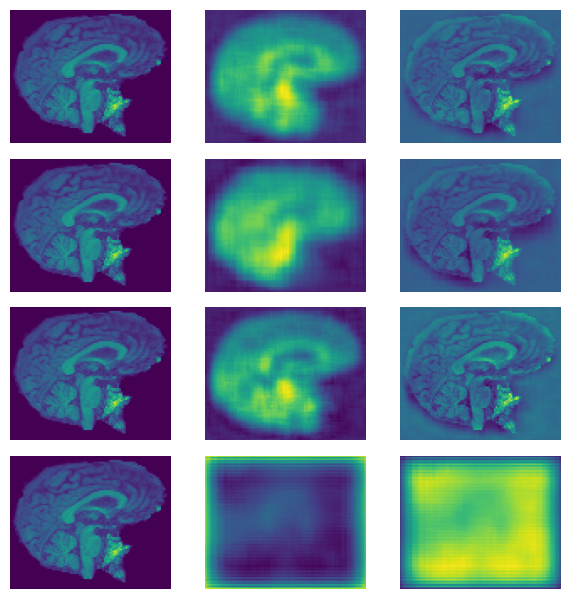

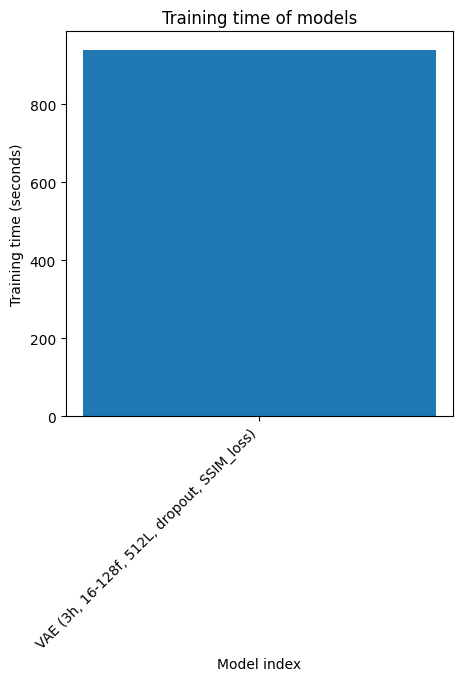

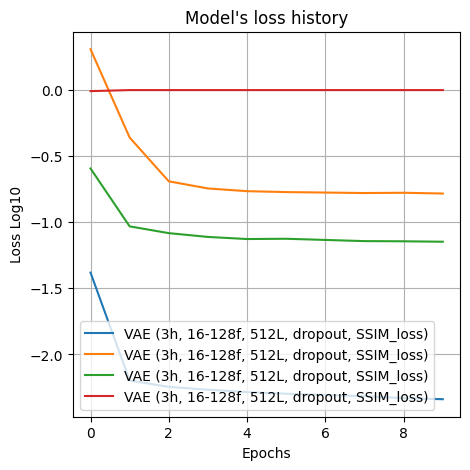

In [32]:
# OGA BOGA MY BRAIN GO FROGA (FRUUUUUUITSZ? NEUUUUUU, ME HATEEY) buuuuu
if 'models_list2' in locals(): # if the variable exists
    images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list2)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list2, fig_size=(5,5))
    compare_models_loss_history(models_list2, log10=True, fig_size=(5,5))

*__Keep in mind__* its plotting different loss functions above, the visual inspection of the reconstruction is what matters.
<table>
    <thead>
        <tr>
            <th>Loss Function</th>
            <th>Pros</th>
            <th>Cons</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><strong>SSIM Loss</strong> (Best for Image Sharpness)</td>
            <td>Preserves high-frequency details</td>
            <td>More computationally expensive</td>
        </tr>
        <tr>
            <td><strong>NRMSE Loss</strong> (Normalized RMSE)</td>
            <td>Normalized for different intensity ranges</td>
            <td>Doesn't directly optimize perceptual quality</td>
        </tr>
        <tr>
            <td><strong>MSE Loss</strong> (Traditional)</td>
            <td>Simple and fast</td>
            <td>Blurs details, penalizes high-intensity areas more</td>
        </tr>
        <tr>
            <td><strong>NMSE Loss</strong> (Normalized MSE)</td>
            <td>Reduces scale dependence</td>
            <td>Similar to MSE in behavior</td>
        </tr>
    </tbody>
</table>


#### You can always keep training any of the models by simply calling train again btw.
Dont be angry at me if your pc crashes like mine.

I GO AUTOMATE the dcf for the economists instead :(evolving dafuq outta dis shit)

moaney flow go brr, skip skip skip

In [73]:
models_list3= [
    AE(name="VAE (3h, 16-128f, 512L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True, loss=SSIM_loss) 
]

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)


In [74]:
for m in models_list3:
    m.train(train, epochs=2, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw)

Training VAE (3h, 16-128f, 512L, dropout, SSIM_loss) on the CPU

NotImplementedError: Iterating over a symbolic KerasTensor is not supported.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step
0.2852847314656359


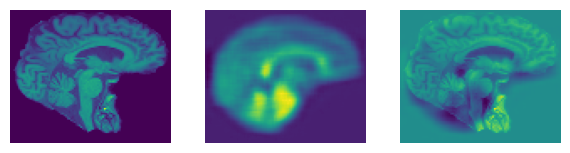

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step
0.36168580553765267


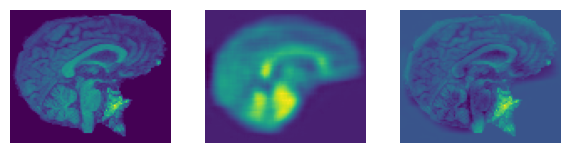

1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


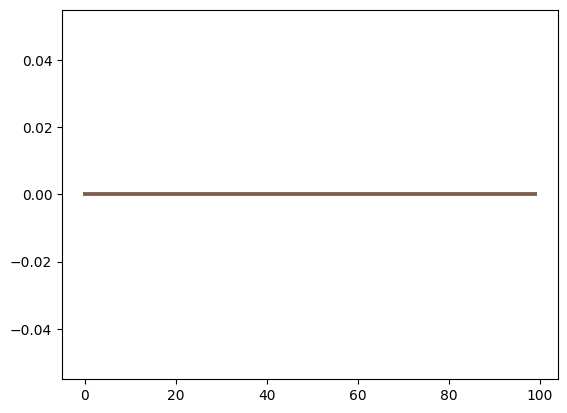

In [69]:
# OGA BOGA MY BRAIN GO FROGA (FRUUUUUUITSZ? NEUUUUUU, ME HATEEY) buuuuu
if 'models_list3' in locals(): # if the variable exists
    images, latent1 = compare_models_reconstruction(brain_scan_id=10, models_list=models_list3)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    #plot_models_training_time(models_list3, fig_size=(5,5))
    #compare_models_loss_history(models_list3, log10=True, fig_size=(5,5))
    images2, latent2 = compare_models_reconstruction(brain_scan_id=0, models_list=models_list3)
    print(SSIM(images2[0], images2[1]))
    plot_images(images2, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    print(SSIM(images[1],images2[1]))

    # print(latent1 == latent2)
    print(latent1, latent2)
    plt.plot(latent1)
    plt.plot(latent2)

Maybe the decoder is just too shallow?

In [12]:
models_list3= [
    AE(name="VAE (3h, 16-128f, 512L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=512,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3DTranspose, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3DTranspose, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3DTranspose, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3D, 1, (3,3,3), {'padding': 'same', 'activation': 'sigmoid'}),  # Final Output
        ], VAE_model=True, loss=SSIM_loss)
]

for m in models_list3:
    m.train(train, epochs=5, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
32/32 ━━━━━━━━━━━━━━━━━━━━ 316s 9s/step - loss: 0.8326 - val_loss: 0.4882
32/32 ━━━━━━━━━━━━━━━━━━━━ 348s 11s/step - loss: 0.4728 - val_loss: 0.3890
32/32 ━━━━━━━━━━━━━━━━━━━━ 308s 9s/step - loss: 0.3953 - val_loss: 0.3769
32/32 ━━━━━━━━━━━━━━━━━━━━ 299s 9s/step - loss: 0.3804 - val_loss: 0.3644
32/32 ━━━━━━━━━━━━━━━━━━━━ 301s 9s/step - loss: 0.3705 - val_loss: 0.3553
 - 1610.52s


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step
0.36168580553765267


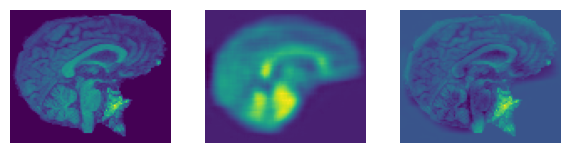

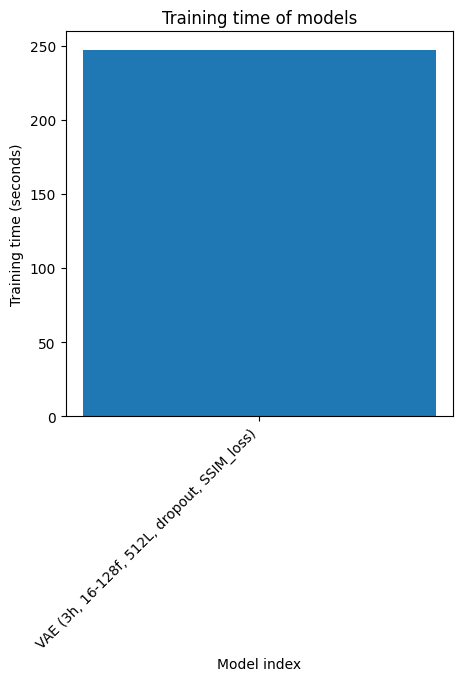

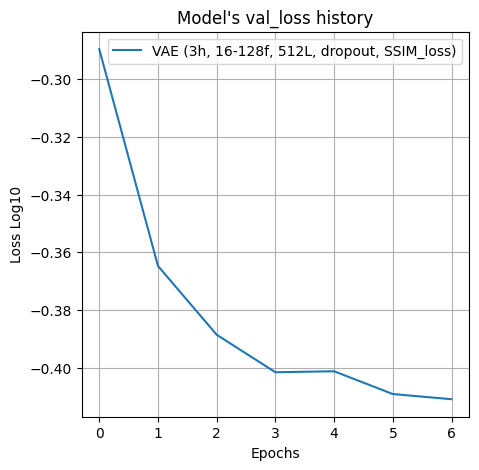

In [63]:
# OGA BOGA MY BRAIN GO FROGA (FRUUUUUUITSZ? NEUUUUUU, ME HATEEY) buuuuu
if 'models_list3' in locals(): # if the variable exists
    images, latent1 = compare_models_reconstruction(brain_scan_id=0, models_list=models_list3)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list3, fig_size=(5,5))
    compare_models_loss_history(models_list3, log10=True, fig_size=(5,5))

In [ ]:
models_list3= [
    AE(name="VAE (3h, 16-128f, 512L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=512,
        encoder_layers=[
                (layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),  # Downsampling
                layers.Dropout(0.05),

                (layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),  # Downsampling
                layers.Dropout(0.05),

                (layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),  # Downsampling
                layers.Dropout(0.05),

                (layers.Conv3D, 128, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra depth  
                (layers.Conv3D, 128, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  
                (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}),  # Downsampling  
        ],
        decoder_layers=[
            (layers.Conv3DTranspose, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3DTranspose, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3DTranspose, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3D, 1, (3,3,3), {'padding': 'same', 'activation': 'sigmoid'}),  # Final Output
        ], VAE_model=True, loss=SSIM_loss)
]

for m in models_list3:
    m.train(train, epochs=5, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw)

In [29]:
models_list3 = [
    AE(name="VAE (3h, 16-128f, 512L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=512,
        encoder_layers=[
            #(layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),

            #(layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),

            #(layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),

            #(layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            #(layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.Activation, 'relu'),
            #(layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            # (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3DTranspose, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            #(layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            #(layers.Conv3D, 64, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3DTranspose, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            #(layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            #(layers.Conv3D, 32, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3DTranspose, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),  
            #(layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer
            #(layers.Conv3D, 16, (3,3,3), {'padding': 'same', 'activation': 'relu'}),  # Extra layer

            (layers.Conv3D, 1, (3,3,3), {'padding': 'same', 'activation': 'sigmoid'}),  # Final Output
        ], VAE_model=True, loss=SSIM_loss)
]


Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)


In [ ]:

for m in models_list3:
    m.train(train, epochs=1, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw)

32/32 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - loss: 0.7677 - val_loss: 0.4637
 - 180.14s


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step
0.26088387555275766


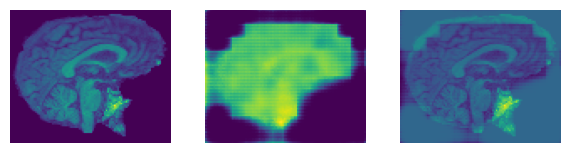

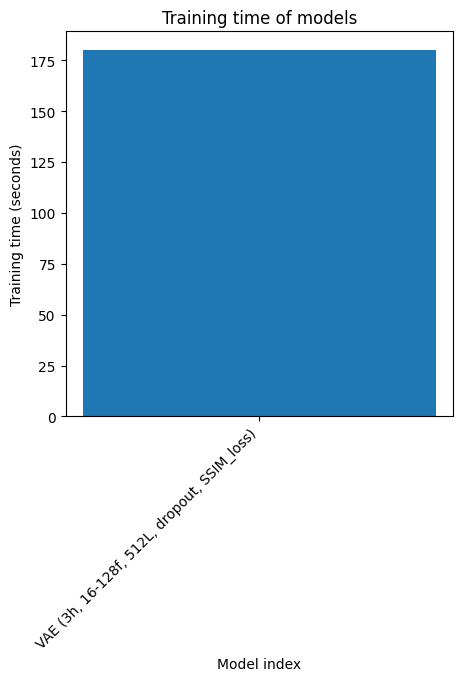

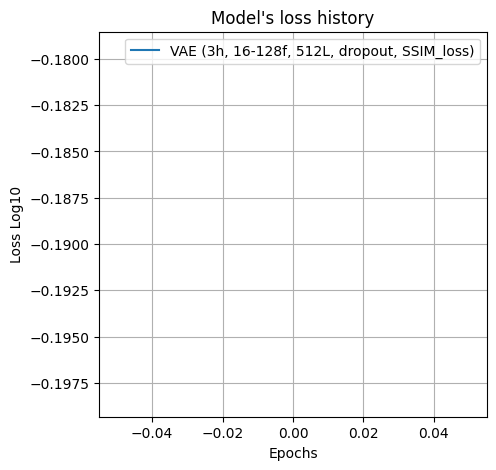

In [31]:
# OGA BOGA MY BRAIN GO FROGA (FRUUUUUUITSZ? NEUUUUUU, ME HATEEY) buuuuu
if 'models_list3' in locals(): # if the variable exists
    images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list3)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list3, fig_size=(5,5))
    compare_models_loss_history(models_list3, log10=True, fig_size=(5,5))

In [9]:
class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                loss="mse", #of any other funciton
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.loss = loss
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        shape_changed = False
        if self.input_shape[-1] > 3:
            self.input_shape = list(self.input_shape) + [1]
            shape_changed = True
        if len(self.input_shape) > 4:
            self.input_shape = self.input_shape[-4:]
            shape_changed = True
        if shape_changed:
            print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        
        # - Add encoder layers
        for layer in self.encoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            print(f"After {x.shape}: {layer}") if self.debug else None

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)

        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            # Sampling layer
            def sampling(args):
                mean, log_var = args
                epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
                return mean + K.exp(log_var / 2) * epsilon
            
            z = layers.Lambda(sampling, name="z")([self.mean, self.log_var])
            self.encoder = Model(input_layer, [self.mean, self.log_var, z], name="encoder")

        else:
            x = layers.Dense(self.latent_dim, activation="relu")(x)
            self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model

        # maybe we can remove this, as the self.latent_dim is the same as x.shape[1:] ? test this once it works.
        if self.VAE_model:
            latent_input = x = layers.Input(shape=(self.latent_dim,))  # Latent input
        else:
            latent_input = x = layers.Input(shape=x.shape[1:])  # Latent input
        
        # Calculate the expected target shape after decoder layers
        target_shape = pre_flatten_shape[1:]

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(target_shape), activation="relu")(latent_input)
        x = layers.Reshape(target_shape)(x)

        # - Add decoder layers
        for layer in self.decoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full VAE
        if self.VAE_model:
            mean, log_var, z = self.encoder(input_layer)
            autoencoder_output = self.decoder(z)
            self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")

        # 3. Combine the encoder and decoder into a full autoencoder
        else:
            autoencoder_output = self.decoder(self.encoder(input_layer))
            self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        
        # 4. GPU or CPU assignment (based on self.GPU)
        #self.autoencoder.compile(optimizer='adam', loss='mse')
        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            # Set device to GPU if available
            with tf.device('/GPU:0'):
                if self.VAE_model:
                    self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)
                else:
                    self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)

        else:
            # Default to CPU
            if self.VAE_model:
                self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)
            else:
                self.autoencoder.compile(optimizer='adam', loss=self.loss)

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        # No reason to delete the loss history, if we stopped the sim at epoch10,
        # then we can continue it at another point
        if not hasattr(self, "history") or not self.history:
            #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
            #self.history.history = {"loss": [], "val_loss": []}
            self.history = {"loss": [], "val_loss": []}

        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0:
                        self.save(save_path, name=f"{self.name}_epoch{epoch}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0:
                    self.save(save_path, name=f"{self.name}_epoch{epoch}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history

    def vae_loss(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""
        reconstruction_loss = self.loss(y_true, y_pred)

        # KL divergence loss
        # mean, log_var = self.encoder.input
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)

        # kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)
    
    #def sample2(mu, logvar):
    #    batch = tf.shape(mu)[0]
    #    dim = tf.shape(mu)[1]
    #    epsilon = tf.random.normal(shape=(batch, dim))
    #    return mu + tf.exp(0.5 * logvar) * epsilon

    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(path, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(path, f"{name}_decoder.keras"))
        print(f"Models saved to {path} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")

        autoencoder = tf.keras.models.load_model(autoencoder_path)
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True
        ae.history = None
        ae.debug = False

        # Compile the loaded model manually
        ae.autoencoder.compile(ae.vae_loss, optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae

In [10]:
models_list4 = [
    AE(name="VAE (3h, 16-128f, 512L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=False, loss=SSIM_loss) 
]

for m in models_list4:
    m.train(train, epochs=1, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.6960 - val_loss: 0.7226
 - 12.9s


In [18]:
# OGA BOGA MY BRAIN GO FROGA (FRUUUUUUITSZ? NEUUUUUU, ME HATEEY) buuuuu
if 'models_list4' in locals(): # if the variable exists
    images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list4)
    images
    #print(SSIM(images[0], images[1]))
    #plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    #plot_models_training_time(models_list4, fig_size=(5,5))
    #compare_models_loss_history(models_list4, log10=True, fig_size=(5,5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


In [30]:
images[0][0].shape

(80, 96)

In [40]:
brain_scan_id = 1
m = models_list4[0]
latent = m.encode(test)
recon = m.decode(latent)
input_image = np.rot90(test[brain_scan_id][40].reshape((96, 80)))
# input_image.shape
#images[]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


IndexError: tuple index out of range